# Calculation of Mean and Covariance

April 20, 2022

The goal of this notebook is to compare simulations with analytic expressions derived by Christian Schmid.

We start with a very general RNN equation with driving input:

$$ \frac{d}{dt}h(t) = W h(t) + \tilde{W} \int_0^t h(s) ds + x + \sigma \xi $$

By introducing $H(t) = \int_0^t h(s) ds$, this equation becomes an Ornstein Uhlenbech process for $\mathbf{H}(t) = \begin{pmatrix} H(t) \\ h(t) \end{pmatrix} $

           

$$ d\mathbf{H}(t) = \boldsymbol\Theta \big( \boldsymbol\mu - \mathbf{H}(t) \big) dt + \boldsymbol\sigma dW $$

Skipping a few steps, we can write the solution as an Ito integral and find the characteristic function

$$ \phi(\mathbf{u}, t) = \mathrm{exp} \big[ i \mathbf{u}^\top (\boldsymbol\mu + e^{-\boldsymbol \Theta t}(\mathbf{H}_0 - \boldsymbol \mu) ) - \frac{1}{2} \mathbf{u}^\top \big( \int_0^t e^{\boldsymbol\Theta(s-t)} \mathbf{D} e^{\boldsymbol \Theta^\top(s-t)} ds \big) \mathbf{u}    \big] $$

Here the mean is

$$ \boldsymbol \mu(t) = \boldsymbol\mu + e^{-\boldsymbol \Theta t}(\mathbf{H}_0 - \boldsymbol \mu)  $$ 

and the covariance is

$$ \int_0^t e^{\boldsymbol\Theta(s-t)} \mathbf{D} e^{\boldsymbol \Theta^\top(s-t)} ds$$

where the diffusion operator is $\mathbf{D}=\boldsymbol \sigma \boldsymbol \sigma^\top$

----

TO DO:
* We want to check that the choice of dt doesn't matter (provided dt is small enough). We want `n_steps*dt = constant`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [6]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories

### Train RNN on four targets using RFLO

In [190]:
trial_duration = 200
n_in=4
frac_on = 1

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

## 1. Training `w_rec` only using RFLO, with velocity transformation

Note that I also had to change the code in the following lines of the RFLO algorithm

```
if 'w_rec' in self.apply_to: 
    self.p = (1-rnn.dt/rnn.tau_rec)*self.p
    self.p += np.outer(rnn.df(rnn.u), rnn.h_prev)*rnn.dt/rnn.tau_rec
if 'w_in' in self.apply_to:
    self.q = (1-rnn.dt/rnn.tau_rec)*self.q
    self.q += np.outer(rnn.df(rnn.u), rnn.x_in_prev)*rnn.dt/rnn.tau_rec  
if 'w_fb' in self.apply_to:
    self.p_fb = (1-rnn.dt/rnn.tau_rec)*self.p_fb
    self.p_fb += np.outer(rnn.df(rnn.u), rnn.pos)*rnn.dt/rnn.tau_rec
```

In [299]:
0.01/0.005

2.0

1it [00:00,  8.05it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.0316227766016838
sig_out: 0.0
tau_rec: 0.5
dt: 0.01
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: True
eta_fb: 0.0
sig_fb: 0.0
feedback_signal: position
velocity_transform: False
tau_vel: 5
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fbafcd6d1b0>
>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


100it [00:02, 33.51it/s]


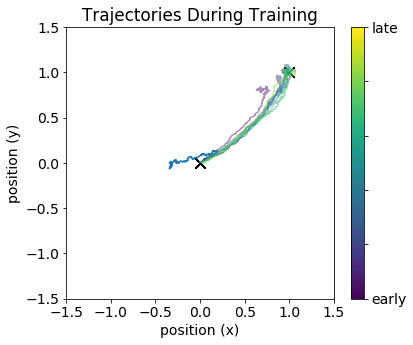

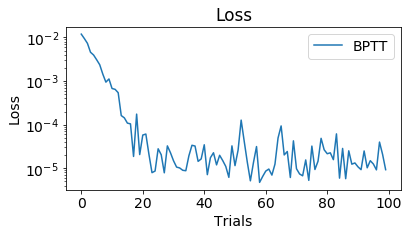

In [301]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=0.5,dt = 0.01, # note that tau_rec and dt are anticorrelated
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.0,
               sig_in=0.0,sig_rec=0.1*np.sqrt(0.1),sig_out=0.0,sig_fb=0.0,
               velocity_transform=False, tau_vel = 5, dt_vel = 0.1,
               driving_feedback=True,
               rng=np.random.RandomState(27))

params.print_params()

# Initialize RNN
net = RNN(params)
#net.set_weights(w_fb=0*net.w_fb)
# initialize simulation
sim = Simulation(net)

bptt = BPTT(net,apply_to=['w_rec','w_out'])

sim.run_session(n_trials=100, tasks=[task1], learn_alg=[bptt], probe_types=['h'], plot=True, plot_freq=10)


100it [00:01, 78.47it/s]


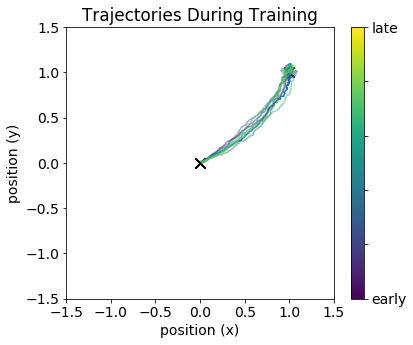

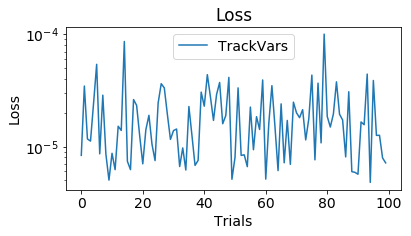

In [302]:
trackvars = TrackVars(net,apply_to=[])

sim.run_session(n_trials=100, tasks=[task1], learn_alg=[trackvars], probe_types=['h'], plot=True, plot_freq=10)

In [274]:
len(sim.session_probes['h'])

100

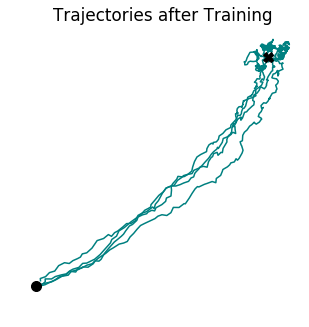

In [303]:
fig = plot_trained_trajectories(sim=sim, tasks=[task1])


What we want to do now is compare _simulated_ mean activity with the analytic expression for mean activity



In [304]:
def calculate_analytic_mean(net,task,sim,t):
    
    """
    The expression for the mean activity at time t is...
    
        mu + np.exp(theta * t) (H0 - mu)
        
    Note that we use the scipy pseudoinverse for stability
        
    TO DO:
    t should be converted to step size
    """
    
    steps = np.arange(0,task.trial_duration)
    
    assert t < task.trial_duration*net.dt, 'time must be less than trial duration'
    assert np.around(t/net.dt,decimals=10) in steps, 'time must be a multiple of net.dt'
    
    t_ind = np.where(np.around(t/net.dt,decimals=10)==steps)[0][0]
    
    activity = sim.session_probes['h'] # get history of activity during trial
    
    # check this negative sign
    mu_1 = -1*LA.pinv2(net.w_fb @ net.w_out) @ (net.w_in @ task1.x_in.T) # scipy pseudo inverse, shape (neurons, timesteps)
    mu_2 = np.zeros(mu_1.shape)
    
    mu = np.concatenate((mu_1[:,t_ind],mu_2[:,t_ind]),axis=0) # only select at time t, resulting in shape (2*neurons,)
    
    theta_11 = np.zeros(net.w_rec.shape)
    theta_12 = -np.eye(net.w_rec.shape[0],net.w_rec.shape[1])
    theta_21 = -net.w_fb @ net.w_out # (neurons,neurons)
    theta_22 = -net.w_rec # (neurons,neurons)
    
    """ construct THETA matrix """
    # stack four matrices
    # final matrix should be shape (2*neurons,2*neurons)
    theta_A = np.concatenate((theta_11, theta_12), axis=1)
    theta_B = np.concatenate((theta_21, theta_22), axis=1)
    theta = np.concatenate((theta_A,theta_B),axis=0)
    
    # ignore H0 for now
    #H0_1 = np.sum(activity) * net.dt # sum of activity, but for initial condition will be zero
    #H0_2 = # activity at time t
    
    analytic_mean = mu + np.exp(-theta*t) @ (-1*mu)
    
    return analytic_mean

In [305]:
task1.trial_duration * net.dt

2.0

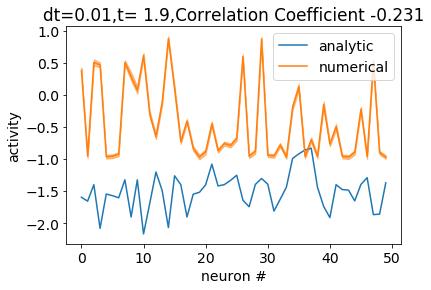

In [309]:

t = 1.9
analytic_mean = calculate_analytic_mean(net,task1,sim,t=t)

steps = np.arange(0,task1.trial_duration)
    
assert t < task1.trial_duration*net.dt, 'time must be less than trial duration'
assert np.around(t/net.dt,decimals=10) in steps, 'time must be a multiple of net.dt'
    
t_ind = np.where(np.around(t/net.dt,decimals=10)==steps)[0][0]

av_activity = np.mean(np.asarray(sim.session_probes['h']),axis=0).squeeze()
activity = av_activity[t_ind,:] # (timesteps, # neurons)
activity_std = np.std(np.asarray(sim.session_probes['h']),axis=0).squeeze()[t_ind,:]

corr = np.corrcoef(analytic_mean[net.n_rec:],activity)[0,1]

plt.plot(analytic_mean[net.n_rec:],label='analytic')
plt.plot(activity,label='numerical')
plt.fill_between(np.arange(0,len(activity)),activity-activity_std,activity+activity_std,alpha=0.5,color='C1')
plt.xlabel('neuron #')
plt.ylabel('activity')
plt.title('dt={},t= {},Correlation Coefficient {:.3f}'.format(net.dt,t,corr))
plt.legend()
plt.show()

In [308]:
av_activity.shape

(200, 50)

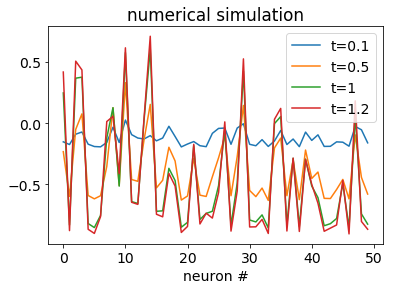

In [294]:
for t in [0.1,0.5,1,1.2]:
    
    steps = np.arange(0,task1.trial_duration)
    
    assert t < task1.trial_duration*net.dt, 'time must be less than trial duration'
    assert np.around(t/net.dt,decimals=10) in steps, 'time must be a multiple of net.dt'

    t_ind = np.where(np.around(t/net.dt,decimals=10)==steps)[0][0]

    av_activity = np.mean(np.asarray(sim.session_probes['h']),axis=0).squeeze()
    activity = av_activity[t_ind,:]
    activity_std = np.std(np.asarray(sim.session_probes['h']),axis=0).squeeze()[t_ind,:]
    
    plt.plot(activity,label='t={}'.format(t))
    


plt.legend()
plt.title('numerical simulation')
plt.xlabel('neuron #')
plt.show()

In [264]:

theta_11 = np.zeros(net.w_rec.shape)
theta_12 = -np.eye(net.w_rec.shape[0],net.w_rec.shape[1])
theta_21 = -net.w_fb @ net.w_out # (neurons,neurons)
theta_22 = -net.w_rec # (neurons,neurons)

# stack four matrices
# final matrix should be shape (2*neurons,2*neurons)
theta_A = np.concatenate((theta_11, theta_12), axis=1)
theta_A.shape

(50, 100)

In [167]:
activity.shape

(1000, 20, 50, 1)

In [251]:
(net.w_in @ task1.x_in.T).shape

(50, 200)

In [282]:
LA.pinv2(0*net.w_fb @ net.w_out)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [75]:
np.linalg.cond(net.w_fb @ net.w_out)

1.0285184564006205e+19

In [76]:
np.finfo((net.w_fb @ net.w_out).dtype).eps

2.220446049250313e-16

In [148]:
t=1.9
steps = np.arange(0,task1.trial_duration)
    
assert np.round(t/net.dt,decimals=10) in steps, 'time must be a multiple of dt'

np.where(np.round(t/net.dt,decimals=10)==steps)[0][0]

19

In [280]:
LA.pinv2(0*net.w_fb @ net.w_out)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [136]:
np.around(1.9/0.1,decimals=10)

19.0

In [113]:
steps

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [33]:
a = np.linalg.inv(net.w_fb @ net.w_out) @ (net.w_in @ task1.x_in.T)
a[1].shape

(20,)

In [23]:
np.linalg.inv(net.w_fb @ net.w_out).shape

(50, 50)

In [25]:
task1.x_in.shape

(20, 4)

In [30]:
a = net.w_in @ task1.x_in.T
a.shape

(50, 20)

In [35]:
a = net.w_fb @ net.w_out
a.shape

(50, 50)

In [37]:
np.zeros(net.w_rec.shape).shape

(50, 50)

In [39]:
np.eye(net.w_rec.shape[0],net.w_rec.shape[1])

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [46]:
t = 10
mu_1 = np.linalg.inv(net.w_fb @ net.w_out) @ (net.w_in @ task1.x_in.T) # (neurons, timesteps)
mu_2 = np.zeros(mu_1.shape)
    
mu = np.concatenate((mu_1[:,t],mu_2[:,t]),axis=0)
mu.shape

(100,)

In [43]:
theta_11 = np.zeros(net.w_rec.shape)
theta_12 = -np.eye(net.w_rec.shape[0],net.w_rec.shape[1])
theta_21 = -net.w_fb @ net.w_out # (neurons,neurons)
theta_22 = -net.w_rec # (neurons,neurons)

# stack four matrices here
theta_A = np.concatenate((theta_11, theta_12), axis=1)
theta_B = np.concatenate((theta_21, theta_22), axis=1)
theta = np.concatenate((theta_A,theta_B),axis=0)

In [44]:
theta.shape

(100, 100)